In [1]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 1.9 MB/s 
     |████████████████████████████████| 6.3 MB 40.7 MB/s 
     |████████████████████████████████| 15.4 MB 42.4 MB/s 


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.utils import resample
from sklearn import linear_model

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import RandomFourierFeatures

import geopandas as gpd
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import time
import ast
import pickle

In [3]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 358 kB/s 


In [4]:
!pip install feature_engine

     |████████████████████████████████| 180 kB 4.2 MB/s 
     |████████████████████████████████| 9.8 MB 24.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [7]:
data_filename = '----dataset mentioned in readme----'
df = pd.read_csv(data_filename)
df.head()

network_code receiver_code  ...    trace_category                 trace_name
0           TA          109C  ...  earthquake_local  109C.TA_20060723155859_EV
1           TA          109C  ...  earthquake_local  109C.TA_20061103155652_EV
2           TA          109C  ...  earthquake_local  109C.TA_20061103161223_EV
3           TA          109C  ...  earthquake_local  109C.TA_20061114133221_EV
4           TA          109C  ...  earthquake_local  109C.TA_20061127104640_EV

[5 rows x 35 columns]

Checking null values in cols

In [8]:
df.isna().sum()

network_code                             55
receiver_code                             0
receiver_type                             0
receiver_latitude                         0
receiver_longitude                        0
receiver_elevation_m                      0
p_arrival_sample                          0
p_status                                  0
p_weight                                175
p_travel_sec                            226
s_arrival_sample                          0
s_status                                  0
s_weight                                155
source_id                                 0
source_origin_time                        0
source_origin_uncertainty_sec        901126
source_latitude                           0
source_longitude                          0
source_error_sec                     578306
source_gap_deg                       659237
source_horizontal_uncertainty_km     599869
source_depth_km                          51
source_depth_uncertainty_km     

In [12]:

label = ['source_magnitude']

Time = ['source_origin_time', 'trace_start_time']

definitely_drop = [
                   # below cols constant values
                   'p_status', 's_status', 'trace_category',
                   # below columns have many NaNs
                   'source_origin_uncertainty_sec', 'source_error_sec', 'source_gap_deg', 'source_horizontal_uncertainty_km','source_depth_uncertainty_km', 
                   'source_magnitude_author', 'source_mechanism_strike_dip_rake',
                   # quite cryptic columns
                   'trace_name', 'receiver_code', # & categorical
                   'snr_db' # it is 3 point array
                   ]

# hash value = i, such that 2^i >= unique values of columns
columns_with_categorical_value_transform_it = [
                                              'network_code', # hash 8
                                              'receiver_type', # hash 4
                                              'source_id', # label encoder or hash 19
                                              'source_magnitude_type', # hash 5
                                              
]

loc_cols = ['receiver_latitude', 'receiver_longitude', 'source_latitude', 'source_longitude']

columns_may_need_normalization = [
                                    'receiver_elevation_m', 'p_arrival_sample','p_travel_sec'
                                  's_arrival_sample', 's_weight', 'source_depth_km',
                                   'source_distance_deg', 'source_distance_km', 'back_azimuth_deg', 'coda_end_sample',

]


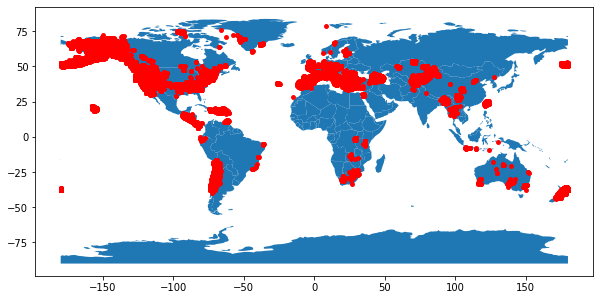

In [10]:
geometry = [Point(xy) for xy in zip(df['source_longitude'], df['source_latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry) 

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 10)), marker='o', color='red', markersize=15);

## Tranforming cyclic features

In [13]:
date_time = pd.to_datetime(df['source_origin_time'])

df['source_origin_time_year'], df['source_origin_time_month'], df['source_origin_time_day'] = date_time.dt.year, date_time.dt.month, date_time.dt.day
df['source_origin_time_hour'] = date_time.dt.hour

# date_time.dt.minute, date_time.dt.second, date_time.dt.microsecond


In [14]:
df['grpId']=df.groupby(['source_latitude','source_longitude',
                  'source_origin_time_year',
                  'source_origin_time_month',
                  'source_origin_time_day',
                  'source_origin_time_hour']).ngroup().add(1)


In [15]:
from sklearn.compose import ColumnTransformer
from feature_engine.creation import CyclicalTransformer
cyclic_cols = ['source_origin_time_month','source_origin_time_day','source_origin_time_hour']

cyclic_features = CyclicalTransformer(variables=None, drop_original=True).fit_transform(df[cyclic_cols])

In [16]:
df = df.drop(cyclic_cols, axis=1)

In [17]:
df = pd.concat([df, cyclic_features], axis=1)

## Transforming Categorical Features

Hash Encoding

In [ ]:

columns_with_categorical_value_transform_it = [
                                              'network_code', # hash 8
                                              'receiver_type', # hash 4
                                              'source_id', # label encoder or hash 19
                                              'source_magnitude_type', # hash 5
                                              
]

Load encoding directly (took time to make encodings)

In [ ]:
# import category_encoders as ce
# encoder=ce.HashingEncoder(cols='network_code',n_components=8)
# network_code = encoder.fit_transform(df['network_code'])

# encoder=ce.HashingEncoder(cols='receiver_type',n_components=4, max_process=4)
# receiver_type = encoder.fit_transform(df['receiver_type'])

# encoder=ce.HashingEncoder(cols='source_id',n_components=19)
# source_id = encoder.fit_transform(df['source_id'])

# encoder=ce.HashingEncoder(cols='source_magnitude_type',n_components=5)
# source_magnitude_type = encoder.fit_transform(df['source_magnitude_type'])

Hash encoded columns saved and pickled as transformation takes time

In [18]:
with open('../data/network_code.pkl','rb') as handle:
    network_code = pickle.load(handle)
with open('../data/receiver_type.pkl','rb') as handle:
    receiver_type = pickle.load(handle)
with open('../data/source_id.pkl','rb') as handle:
    source_id = pickle.load(handle)
with open('../data/source_magnitude_type.pkl','rb') as handle:
    source_magnitude_type = pickle.load(handle)

In [19]:
df = df.drop(columns_with_categorical_value_transform_it, axis=1)

Column names can be same of hash encoding renaming it

In [20]:
network_code.rename({col:'network_code_'+col for col in network_code.columns}, axis=1, inplace=True)
receiver_type.rename({col:'receiver_type_'+col for col in receiver_type.columns}, axis=1, inplace=True)
source_id.rename({col:'source_id_'+col for col in source_id.columns}, axis=1, inplace=True)
source_magnitude_type.rename({col:'source_magnitude_type_'+col for col in source_magnitude_type.columns}, axis=1, inplace=True)

In [21]:
df = pd.concat([df, network_code], axis=1)
df = pd.concat([df, receiver_type], axis=1)
df = pd.concat([df, source_id], axis=1)
df = pd.concat([df, source_magnitude_type], axis=1)

In [22]:
df

receiver_code  ...  source_magnitude_type_col_4
0                109C  ...                            1
1                109C  ...                            0
2                109C  ...                            1
3                109C  ...                            1
4                109C  ...                            1
...               ...  ...                          ...
1058949           YHL  ...                            0
1058950           YHL  ...                            1
1058951           YHL  ...                            1
1058952           YHL  ...                            1
1058953           YHL  ...                            0

[1058954 rows x 76 columns]

Label Encoding \\
! Caution : Reduced Performance

In [ ]:
# encoder= ce.OrdinalEncoder(cols=columns_with_categorical_value_transform_it)
# df = encoder.fit_transform(df)

## Lat Long transformed using clustering

Not much improvement

In [11]:
lat_long = set(zip(df['source_latitude'], df['source_longitude']))
lat_long = np.array(list(lat_long))
lat_long

array([[  39.3899   ,   70.7055   ],
       [  39.6316   , -120.0145   ],
       [  39.4008   , -120.5657   ],
       ...,
       [  38.546    , -118.4731   ],
       [  38.8458328, -122.8221664],
       [  37.5655   , -118.88633  ]])

In [ ]:
clust = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05)
# clust.fit(lat_long)

In [ ]:
with open('../models/optics-Lat-Long-ClusterObject.pkl', 'rb') as handle:
    clust = pickle.load(handle)

In [ ]:
labels_050 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=2,
)

In [ ]:
lat_long_cluster = {}
for lt_lg, cluster_id in zip(lat_long, labels_050):
    lat_long_cluster[(lt_lg[0],lt_lg[1])] = cluster_id

In [ ]:
df['cluster_id'] = df.apply(lambda row: lat_long_cluster[(row['source_latitude'], row['source_longitude'])], axis=1)

## Drop unnecesary columns

In [23]:
X = df.drop(Time+definitely_drop+[label[0]], axis=1)
y = df[label[0]]

Extract group id

In [24]:
grpId = X.grpId.to_numpy()

In [25]:
X = X.drop('grpId',axis=1)

In [26]:
feature_names = list(X.columns)

## Replace Null Values


In [27]:
X = X.fillna(X.mean())

In [28]:
X.shape

(1058954, 59)

Making X & y numpy

In [29]:
X = X.to_numpy()
y = y.to_numpy()

## Normalize values

In [ ]:
# Standard normalization
# X = (X-X.mean())/X.std()

# Min-Max normalization
# X = (X-X.min())/(X.max()-X.min())

## Split into Train and Test samples

Shuffle instances

In [30]:
randomize = np.arange(len(X))
np.random.shuffle(randomize)
X_shuffled = X[randomize]
y_shuffled = y[randomize]
grpId_shuffled = grpId[randomize]

Group kfold

In [31]:
from sklearn.model_selection import GroupKFold

group_kfold = GroupKFold(n_splits=5)

Train test group split 3 FOLD- Train, Validation, Test

In [32]:
from sklearn.model_selection import GroupShuffleSplit

# 60% Train, 20% Val, 20% Test
gs = GroupShuffleSplit(n_splits=1, test_size=.4, random_state=0)
train_ix, test_ix = next(gs.split(X, y, groups=grpId))

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST, grpId_TRAIN, grpId_TEST = X[train_ix], X[test_ix], y[train_ix], y[test_ix], grpId[train_ix], grpId[test_ix]

gs = GroupShuffleSplit(n_splits=1, test_size=.5, random_state=0)
val_ix, test_ix = next(gs.split(X_TEST, Y_TEST, groups=grpId_TEST))

X_VAL, X_TEST, Y_VAL, Y_TEST, grpId_VAL, grpId_TEST = X_TEST[val_ix], X_TEST[test_ix], Y_TEST[val_ix], Y_TEST[test_ix], grpId_TEST[val_ix], grpId_TEST[test_ix]

In [33]:
print("\tX\tY\tGrp")
print('Train:', X_TRAIN.shape, Y_TRAIN.shape, grpId_TRAIN.shape)
print('Validation:', X_VAL.shape, Y_VAL.shape, grpId_VAL.shape)
print('Test:', X_TEST.shape, Y_TEST.shape, grpId_TEST.shape)

	X	Y	Grp
Train: (635383, 59) (635383,) (635383,)
Validation: (211990, 59) (211990,) (211990,)
Test: (211581, 59) (211581,) (211581,)


Replace negative values with mean of lower magnitude earthquakes

In [34]:
REP_NEG = np.mean(Y_TRAIN[Y_TRAIN<3])
REP_NEG

1.296420230700976

# **Linear Regression**

In [ ]:
i=0
sum_rms, sum_mae = 0, 0
for train_index, test_index in group_kfold.split(X_shuffled, y_shuffled, grpId_shuffled):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr = linear_model.LinearRegression().fit(X_train, y_train)
    y_pred = lr.predict(X_test)

    # replace negative values
    rep_neg = np.mean(y_train[y_train<3])
    rep_neg
    y_pred[y_pred<0] = rep_neg
    rms = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)

    sum_rms += rms
    sum_mae += mae
    i += 1
    print("Itr {} :- RMSE:{}, MAE:{}".format(i, round(rms,4), round(mae,4)))
print("For {} Folds:- Avg RMSE: {}, Avg MAE: {}".format(i, round(sum_rms/i,4), round(sum_mae/i,4)))

Itr 1 :- RMSE:0.6291, MAE:0.4932
Itr 2 :- RMSE:0.6275, MAE:0.4927
Itr 3 :- RMSE:0.6304, MAE:0.4939
Itr 4 :- RMSE:0.6284, MAE:0.4927
Itr 5 :- RMSE:0.6271, MAE:0.4918
For 5 Folds:- Avg RMSE: 0.6285, Avg MAE: 0.4929


# **Lasso Regression**

In [ ]:
lasso_alphas = np.linspace(0, 0.2, 21)
grid = dict()
grid['alpha'] = lasso_alphas[1:]
gscv = GridSearchCV(
    linear_model.Lasso(random_state=42), grid,
    cv = GroupKFold(n_splits=3).get_n_splits(X_TRAIN, Y_TRAIN, grpId_TRAIN),
    verbose=4,
    )
results = gscv.fit(X_TRAIN, Y_TRAIN)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END ........................alpha=0.01;, score=0.509 total time=  16.5s
[CV 2/3] END ........................alpha=0.01;, score=0.617 total time=  14.3s
[CV 3/3] END ........................alpha=0.01;, score=0.545 total time=   8.9s
[CV 1/3] END ........................alpha=0.02;, score=0.496 total time=  10.6s
[CV 2/3] END ........................alpha=0.02;, score=0.599 total time=  12.7s
[CV 3/3] END ........................alpha=0.02;, score=0.511 total time=   9.0s
[CV 1/3] END ........................alpha=0.03;, score=0.483 total time=   9.6s
[CV 2/3] END ........................alpha=0.03;, score=0.584 total time=  11.2s
[CV 3/3] END ........................alpha=0.03;, score=0.502 total time=   8.1s
[CV 1/3] END ........................alpha=0.04;, score=0.471 total time=   7.2s
[CV 2/3] END ........................alpha=0.04;, score=0.580 total time=  10.3s
[CV 3/3] END ........................alpha=0.04;

In [ ]:
# with open('../models/lasso_gridsearch.pkl', 'rb') as handle:
#     results = pickle.load(handle)

In [ ]:
results.best_params_

{'alpha': 0.01}

In [ ]:

i=0
sum_rms, sum_mae = 0, 0
for train_index, test_index in group_kfold.split(X_shuffled, y_shuffled, grpId_shuffled):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    lassoReg = linear_model.Lasso(alpha=0.01)
    lassoReg.fit(X_train, y_train)
    y_pred = lassoReg.predict(X_test)

    # replace negative values
    rep_neg = np.mean(y_train[y_train<3])
    rep_neg
    y_pred[y_pred<0] = rep_neg
    rms = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)

    sum_rms += rms
    sum_mae += mae
    i += 1
    print("Itr {} :- RMSE:{}, MAE:{}".format(i, round(rms,4), round(mae,4)))
print("For {} Folds:- Avg RMSE: {}, Avg MAE: {}".format(i, round(sum_rms/i,4), round(sum_mae/i,4)))

Itr 1 :- RMSE:0.6333, MAE:0.4975
Itr 2 :- RMSE:0.6321, MAE:0.4976
Itr 3 :- RMSE:0.6305, MAE:0.4958
Itr 4 :- RMSE:0.6301, MAE:0.4966
Itr 5 :- RMSE:0.63, MAE:0.4958
For 5 Folds:- Avg RMSE: 0.6312, Avg MAE: 0.4967


# **Ridge Regression**

In [ ]:
grid = dict()
grid['alpha'] = np.linspace(0.2, 0.5, 10)
gscv = GridSearchCV(
    linear_model.Ridge(random_state=42), grid,
    cv = GroupKFold(n_splits=3).get_n_splits(X_TRAIN, Y_TRAIN, grpId_TRAIN),
    verbose=4,
    )
results = gscv.fit(X_TRAIN, Y_TRAIN)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END .........................alpha=0.2;, score=0.511 total time=   0.4s
[CV 2/3] END .........................alpha=0.2;, score=0.633 total time=   0.5s
[CV 3/3] END .........................alpha=0.2;, score=0.574 total time=   0.5s
[CV 1/3] END .........alpha=0.23333333333333334;, score=0.511 total time=   0.5s
[CV 2/3] END .........alpha=0.23333333333333334;, score=0.633 total time=   0.5s
[CV 3/3] END .........alpha=0.23333333333333334;, score=0.574 total time=   0.5s
[CV 1/3] END .........alpha=0.26666666666666666;, score=0.511 total time=   0.4s
[CV 2/3] END .........alpha=0.26666666666666666;, score=0.633 total time=   0.5s
[CV 3/3] END .........alpha=0.26666666666666666;, score=0.574 total time=   0.4s
[CV 1/3] END .........alpha=0.30000000000000004;, score=0.511 total time=   0.4s
[CV 2/3] END .........alpha=0.30000000000000004;, score=0.633 total time=   0.5s
[CV 3/3] END .........alpha=0.30000000000000004;

In [ ]:
# with open('../models/ridge_gridsearch.pkl', 'rb') as handle:
#     results = pickle.load(handle)

In [ ]:
results.best_params_

{'alpha': 0.5}

In [ ]:
i=0
sum_rms, sum_mae = 0, 0
for train_index, test_index in group_kfold.split(X_shuffled, y_shuffled, grpId_shuffled):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    ridgeReg = linear_model.Ridge(alpha=0.5)
    ridgeReg.fit(X_train, y_train)
    y_pred = ridgeReg.predict(X_test)

    # replace negative values
    rep_neg = np.mean(y_train[y_train<3])
    rep_neg
    y_pred[y_pred<0] = rep_neg
    rms = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)

    sum_rms += rms
    sum_mae += mae
    i += 1
    print("Itr {} :- RMSE:{}, MAE:{}".format(i, round(rms,4), round(mae,4)))
print("For {} Folds:- Avg RMSE: {}, Avg MAE: {}".format(i, round(sum_rms/i,4), round(sum_mae/i,4)))

Itr 1 :- RMSE:0.6291, MAE:0.4932
Itr 2 :- RMSE:0.6275, MAE:0.4927
Itr 3 :- RMSE:0.6304, MAE:0.4939
Itr 4 :- RMSE:0.6284, MAE:0.4927
Itr 5 :- RMSE:0.6271, MAE:0.4918
For 5 Folds:- Avg RMSE: 0.6285, Avg MAE: 0.4929


# **Support Vector Regression**

Quasi-SVM

In [ ]:

model = keras.Sequential(
    [
        keras.Input(shape=(X_TRAIN.shape[1],)),
        RandomFourierFeatures(
            output_dim=2048, scale=10.0, kernel_initializer="gaussian"
        ),
        layers.Dense(units=1)
    ]
)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.hinge,
    metrics=[keras.metrics.RootMeanSquaredError(name="rmse")],
)


In [ ]:
filepath="--your-path/quasi-svm-ep{epoch:03d}-loss{loss:.3f}-rmse{rmse:.3f}-val_loss{val_loss:.3f}-val_rmse{val_rmse:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath,
                            monitor='val_rmse',
                            verbose=1,
                            save_best_only=True,
                            mode='min')
history = model.fit(
    X_TRAIN, 
    Y_TRAIN, 
    epochs=5, 
    batch_size=128,
    validation_data=(X_VAL, Y_VAL),
    callbacks = [checkpoint]
)

Epoch 1/5
4963/4964 [============================>.] - ETA: 0s - loss: 0.1756 - rmse: 1.2216
Epoch 00001: val_rmse improved from inf to 1.16181, saving model to /content/drive/MyDrive/FML/training_NN_model/quasi-svm-ep001-loss0.176-rmse1.222-val_loss0.042-val_rmse1.162.hdf5
4964/4964 [==============================] - 24s 5ms/step - loss: 0.1755 - rmse: 1.2216 - val_loss: 0.0423 - val_rmse: 1.1618
Epoch 2/5
4955/4964 [============================>.] - ETA: 0s - loss: 0.0288 - rmse: 1.8405
Epoch 00002: val_rmse did not improve from 1.16181
4964/4964 [==============================] - 23s 5ms/step - loss: 0.0288 - rmse: 1.8421 - val_loss: 0.0164 - val_rmse: 2.6909
Epoch 3/5
4963/4964 [============================>.] - ETA: 0s - loss: 0.0151 - rmse: 3.8754
Epoch 00003: val_rmse did not improve from 1.16181
4964/4964 [==============================] - 23s 5ms/step - loss: 0.0151 - rmse: 3.8757 - val_loss: 0.0089 - val_rmse: 5.2194
Epoch 4/5
4958/4964 [============================>.] - ETA:

In [ ]:
y_pred = keras.models.load_model('../models/quasi-svm-ep001-loss0.176-rmse1.222-val_loss0.042-val_rmse1.162.hdf5',
custom_objects={"RandomFourierFeatures": RandomFourierFeatures }
).predict(X_TEST)
rms = mean_squared_error(Y_TEST, y_pred, squared=False)
rms

1.190895467143891

In [ ]:
mean_absolute_error(Y_TEST, y_pred)

1.007115856517492

Sklearn SVM

In [ ]:
from sklearn.svm import SVR

# svr = SVR(kernel='rbf').fit(X_VAL[:100000], Y_VAL[:100000])

In [ ]:
 with open('../models/svr-100kval-test.pkl', 'rb') as handle:
    svr = pickle.load(handle)

In [ ]:
y_pred = svr.predict(X_TEST)
rms = mean_squared_error(Y_TEST, y_pred, squared=False)
rms

0.6671200922917695

In [ ]:
mean_absolute_error(Y_TEST, y_pred)

0.4994767667774198

# **Decision Tree Regressor**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
dt_rand_grid = RandomizedSearchCV(estimator=DecisionTreeRegressor(),
                       param_distributions = parameters,
                       n_iter = 2000,
                       cv = list(GroupKFold(n_splits=3).split(X_TRAIN, Y_TRAIN, grpId_TRAIN)),
                       verbose=4
                       )
# dt_reg = dt_rand_grid.fit(X_TRAIN,Y_TRAIN)

Streaming output truncated to the last 5000 lines.
[CV 1/3] END max_depth=9, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best;, score=0.239 total time=   0.4s
[CV 2/3] END max_depth=9, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best;, score=0.048 total time=   0.4s
[CV 3/3] END max_depth=9, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best;, score=0.004 total time=   0.3s
[CV 1/3] END max_depth=9, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random;, score=nan total time=   0.2s
[CV 2/3] END max_depth=9, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random;, score=nan total time=   0.2s
[CV 3/3] END max_depth=9, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random;, score=nan to

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
2601 fits failed out of a total of 6000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2601 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 1320, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 304, in fit
    raise ValueError("min_weight_fraction_leaf must in [0, 0.5]")
ValueError: min_weight_fraction_

In [ ]:
dt_reg =  pickle.load(open('../models/decision_tree_reg-2000-_randomsearchcv_reg.pkl','rb'))

In [ ]:
dt_reg.best_params_

{'max_depth': 9,
 'max_features': 'auto',
 'max_leaf_nodes': 50,
 'min_samples_leaf': 2,
 'min_weight_fraction_leaf': 0.1,
 'splitter': 'best'}

In [ ]:
param_grid = {'max_depth': [9,None],
 'max_features': ['auto',None],
 'max_leaf_nodes':[ 50,None],
 'min_weight_fraction_leaf': [0.1,0],
}
dt_reg_grid = GridSearchCV(
            estimator=DecisionTreeRegressor(),
            param_grid = param_grid,
            cv = list(GroupKFold(n_splits=3).split(X_TRAIN, Y_TRAIN, grpId_TRAIN)),
            verbose=4
)
# dt_reg_grid.fit(X_TRAIN,Y_TRAIN)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END max_depth=9, max_features=auto, max_leaf_nodes=50, min_weight_fraction_leaf=0.1;, score=0.590 total time=   5.0s
[CV 2/3] END max_depth=9, max_features=auto, max_leaf_nodes=50, min_weight_fraction_leaf=0.1;, score=0.590 total time=   5.5s
[CV 3/3] END max_depth=9, max_features=auto, max_leaf_nodes=50, min_weight_fraction_leaf=0.1;, score=0.588 total time=   5.4s
[CV 1/3] END max_depth=9, max_features=auto, max_leaf_nodes=50, min_weight_fraction_leaf=0;, score=0.743 total time=  10.0s
[CV 2/3] END max_depth=9, max_features=auto, max_leaf_nodes=50, min_weight_fraction_leaf=0;, score=0.744 total time=  10.2s
[CV 3/3] END max_depth=9, max_features=auto, max_leaf_nodes=50, min_weight_fraction_leaf=0;, score=0.742 total time=   9.9s
[CV 1/3] END max_depth=9, max_features=auto, max_leaf_nodes=None, min_weight_fraction_leaf=0.1;, score=0.590 total time=   5.5s
[CV 2/3] END max_depth=9, max_features=auto, max_leaf_nodes=N

GridSearchCV(cv=[(array([     1,      2,      4, ..., 742636, 742638, 742641]),
                  array([     0,      3,      5, ..., 742637, 742639, 742640])),
                 (array([     0,      2,      3, ..., 742637, 742639, 742640]),
                  array([     1,      7,     11, ..., 742630, 742638, 742641])),
                 (array([     0,      1,      3, ..., 742639, 742640, 742641]),
                  array([     2,      4,      8, ..., 742632, 742635, 742636]))],
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [9, None], 'max_features': ['auto', None],
                         'max_leaf_nodes': [50, None],
                         'min_weight_fraction_leaf': [0.1, 0]},
             verbose=4)

In [ ]:
dt_reg_grid = pickle.load(open('../models/decision_tree_reg-default_gridsearchcv_reg.pkl','rb'))

In [ ]:
dt_reg_grid.best_params_

{'max_depth': 9,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_weight_fraction_leaf': 0}

tuned hyperparameters

In [ ]:
y_pred = dt_reg_grid.best_estimator_.predict(X_TEST)
y_pred[y_pred<0] = REP_NEG
rms = mean_squared_error(Y_TEST, y_pred, squared=False)
rms

0.4895462282011727

In [ ]:
mae = mean_absolute_error(Y_TEST, y_pred)
mae

0.3754817313648722

default parameters

In [ ]:
decisionTreeReg = DecisionTreeRegressor()
decisionTreeReg.fit(X_TRAIN, Y_TRAIN)
y_pred = decisionTreeReg.predict(X_TEST)
y_pred[y_pred<0] = REP_NEG
rms = mean_squared_error(Y_TEST, y_pred, squared=False)
rms

0.5585691579872178

In [ ]:
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(dt_reg_grid.best_estimator_,
                                out_file=None,
                                feature_names=feature_names,    
                      filled=True, rounded=True,  
                      special_characters=True)
graph = graphviz.Source(dot_data) 
graph


In [ ]:
from sklearn.tree import export_text
r = export_text(clf_model, feature_names=feature_names)
print(r)

|--- coda_end_sample <= 3199.50
|   |--- p_weight <= 0.50
|   |   |--- p_weight <= 0.00
|   |   |   |--- receiver_latitude <= 50.30
|   |   |   |   |--- receiver_latitude <= 35.68
|   |   |   |   |   |--- source_distance_km <= 54.49
|   |   |   |   |   |   |--- source_magnitude_type_col_4 <= 0.50
|   |   |   |   |   |   |   |--- source_longitude <= -121.12
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- source_longitude >  -121.12
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- source_magnitude_type_col_4 >  0.50
|   |   |   |   |   |   |   |--- receiver_longitude <= -117.09
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- receiver_longitude >  -117.09
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- source_distance_km >  54.49
|   |   |   |   |   |   |--- source_distance_deg <= 1.00
|   |   |   |   |   |   |   |--- network_code_col_0 <= 0.50
|   |   |   |   |   |   |   |   |--

In [ ]:
graph.render('graph_tree_reg',format='png', view=False)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.294723 to fit


'graph_tree_reg.png'

# **xgboost**

In [ ]:
from xgboost import XGBRegressor
# tune tomorrow one by one with next tab
                    
param_test1 = {
    # 5 fold
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

# 3 folds to save time for all sets below

param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

param_test4 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}

param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

param_test6 = { 
              'learning_rate': [i/100 for i in range(1,31)], 
}

fit_params = {
              'objective':'reg:linear', 
              'eval_metric':'rmse', 
              'verbose':True, 
              'n_jobs' : -1, 
              'eval_set' : [(X_VAL, Y_VAL)],
              'silent':1,
              'early_stopping_rounds':10,
              'seed':42,
              'scale_pos_weight':1,
}

In [ ]:
xgb_grid = GridSearchCV(XGBRegressor(objective='reg:linear',eval_metric='rmse', verbose=True, n_jobs=-1,
                                     eval_set=[(X_VAL, Y_VAL)], early_stopping_rounds=10, seed=42, silent=1,scale_pos_weight=1),
                        param_test1,
                        cv = GroupKFold(n_splits=5).get_n_splits(X_TRAIN, Y_TRAIN, grpId_TRAIN),
                        verbose=4)

# xgb_grid.fit(X_TRAIN, Y_TRAIN)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ...max_depth=3, min_child_weight=1;, score=0.721 total time= 1.3min
[CV 2/5] END ...max_depth=3, min_child_weight=1;, score=0.654 total time= 1.3min
[CV 3/5] END ...max_depth=3, min_child_weight=1;, score=0.759 total time= 1.2min
[CV 4/5] END ...max_depth=3, min_child_weight=1;, score=0.760 total time= 1.2min
[CV 5/5] END ...max_depth=3, min_child_weight=1;, score=0.746 total time= 1.2min
[CV 1/5] END ...max_depth=3, min_child_weight=3;, score=0.721 total time= 1.2min
[CV 2/5] END ...max_depth=3, min_child_weight=3;, score=0.654 total time= 1.2min
[CV 3/5] END ...max_depth=3, min_child_weight=3;, score=0.759 total time= 1.2min
[CV 4/5] END ...max_depth=3, min_child_weight=3;, score=0.760 total time= 1.2min
[CV 5/5] END ...max_depth=3, min_child_weight=3;, score=0.746 total time= 1.3min
[CV 1/5] END ...max_depth=3, min_child_weight=5;, score=0.721 total time= 1.2min
[CV 2/5] END ...max_depth=3, min_child_weight=5;

GridSearchCV(cv=5,
             estimator=XGBRegressor(early_stopping_rounds=10,
                                    eval_metric='rmse',
                                    eval_set=[(array([[ 3.288890e+01, -1.171051e+02,  1.500000e+02, ...,  0.000000e+00,
         0.000000e+00,  1.000000e+00],
       [ 3.288890e+01, -1.171051e+02,  1.500000e+02, ...,  0.000000e+00,
         0.000000e+00,  1.000000e+00],
       [ 3.288890e+01, -1.171051e+02,  1.500000e+02, ...,  0.000000e+00,
         0.000000e+00,  1.0000...
         0.000000e+00,  1.000000e+00],
       [ 3.920770e+01, -1.201260e+02,  2.147000e+03, ...,  0.000000e+00,
         0.000000e+00,  1.000000e+00],
       [ 3.920770e+01, -1.201260e+02,  2.147000e+03, ...,  0.000000e+00,
         0.000000e+00,  1.000000e+00]]),
                                               array([ 3.6,  3.6,  3.6, ...,  0.1, -0. ,  0.4]))],
                                    n_jobs=-1, seed=42, silent=1,
                                    verbose=True),
    

In [35]:
with open('../models/xgb_cv_param_test1.pkl', 'rb') as handle:
    xgb_cv_param_test1 = pickle.load(handle)

[08:21:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print(xgb_cv_param_test1.best_score_)
print(xgb_cv_param_test1.best_params_)

0.7757026612081794
{'max_depth': 9, 'min_child_weight': 3}


In [ ]:
y_pred = xgb_cv_param_test1.best_estimator_.predict(X_TEST)
y_pred[y_pred<0] = REP_NEG
rms = mean_squared_error(Y_TEST, y_pred, squared=False)
mae = mean_absolute_error(Y_TEST, y_pred)
print('RMSE:',rms)
print('MAE:',mae)

RMSE: 0.40958623404706246
MAE: 0.3106693113035759


Using previous best parameters and tuning next set of hyperparameters

In [ ]:
xgb_grid = GridSearchCV(XGBRegressor(objective='reg:linear',eval_metric='rmse', verbose=True, n_jobs=-1,
                                     eval_set=[(X_VAL, Y_VAL)], early_stopping_rounds=10, seed=42, silent=1,scale_pos_weight=1,
                                     max_depth=9, min_child_weight=3,
                                     ),
                        param_test2,
                        cv = GroupKFold(n_splits=3).get_n_splits(X_TRAIN, Y_TRAIN, grpId_TRAIN),
                        verbose=4)

# xgb_grid.fit(X_TRAIN, Y_TRAIN)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END .........................gamma=0.0;, score=0.700 total time= 3.6min
[CV 2/3] END .........................gamma=0.0;, score=0.735 total time= 3.6min
[CV 3/3] END .........................gamma=0.0;, score=0.815 total time= 3.6min
[CV 1/3] END .........................gamma=0.1;, score=0.711 total time= 3.6min
[CV 2/3] END .........................gamma=0.1;, score=0.747 total time= 3.6min
[CV 3/3] END .........................gamma=0.1;, score=0.812 total time= 3.5min
[CV 1/3] END .........................gamma=0.2;, score=0.698 total time= 3.6min
[CV 2/3] END .........................gamma=0.2;, score=0.747 total time= 3.6min
[CV 3/3] END .........................gamma=0.2;, score=0.813 total time= 3.5min
[CV 1/3] END .........................gamma=0.3;, score=0.704 total time= 3.6min
[CV 2/3] END .........................gamma=0.3;, score=0.744 total time= 3.6min
[CV 3/3] END .........................gamma=0.3;,

GridSearchCV(cv=3,
             estimator=XGBRegressor(early_stopping_rounds=10,
                                    eval_metric='rmse',
                                    eval_set=[(array([[ 3.288890e+01, -1.171051e+02,  1.500000e+02, ...,  0.000000e+00,
         0.000000e+00,  1.000000e+00],
       [ 3.288890e+01, -1.171051e+02,  1.500000e+02, ...,  0.000000e+00,
         0.000000e+00,  1.000000e+00],
       [ 3.288890e+01, -1.171051e+02,  1.500000e+02, ...,  0.000000e+00,
         0.000000e+00,  1.0000...
         0.000000e+00,  1.000000e+00],
       [ 3.920770e+01, -1.201260e+02,  2.147000e+03, ...,  0.000000e+00,
         0.000000e+00,  1.000000e+00],
       [ 3.920770e+01, -1.201260e+02,  2.147000e+03, ...,  0.000000e+00,
         0.000000e+00,  1.000000e+00]]),
                                               array([ 3.6,  3.6,  3.6, ...,  0.1, -0. ,  0.4]))],
                                    max_depth=9, min_child_weight=3, n_jobs=-1,
                                    seed=

In [ ]:
with open('../models/xgb_cv_param_test2.pkl', 'rb') as handle:
    xgb_cv_param_test2 = pickle.load(handle)

[14:27:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print(xgb_cv_param_test2.best_score_)
print(xgb_cv_param_test2.best_params_)

0.7567583567209429
{'gamma': 0.1}


In [ ]:
y_pred = xgb_cv_param_test2.best_estimator_.predict(X_TEST)
y_pred[y_pred<0] = REP_NEG
rms = mean_squared_error(Y_TEST, y_pred, squared=False)
mae = mean_absolute_error(Y_TEST, y_pred)
print('RMSE:',rms)
print('MAE:',mae)

RMSE: 0.40968695274879
MAE: 0.3109184782850907


param set 3

In [ ]:
xgb_grid = GridSearchCV(XGBRegressor(objective='reg:linear',eval_metric='rmse', verbose=True, n_jobs=-1,
                                     eval_set=[(X_VAL, Y_VAL)], early_stopping_rounds=10, seed=42, silent=1,scale_pos_weight=1,
                                     max_depth=9, min_child_weight=3,
                                     gamma = 0.1,
                                     ),
                        param_test3,
                        cv = GroupKFold(n_splits=3).get_n_splits(X_TRAIN, Y_TRAIN, grpId_TRAIN),
                        verbose=4)

# xgb_grid.fit(X_TRAIN, Y_TRAIN)

In [ ]:
with open('../models/xgb_cv_param_test3.pkl', 'rb') as handle:
    xgb_cv_param_test3 = pickle.load(handle)

[14:27:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print('Best score:',xgb_cv_param_test3.best_score_)
print('Best Parameters:',xgb_cv_param_test3.best_params_)
y_pred = xgb_cv_param_test3.best_estimator_.predict(X_TEST)
y_pred[y_pred<0] = REP_NEG
rms = mean_squared_error(Y_TEST, y_pred, squared=False)
mae = mean_absolute_error(Y_TEST, y_pred)
print('RMSE:',rms)
print('MAE:',mae)

Best score: 0.7550902129143102
Best Parameters: {'colsample_bytree': 0.8, 'subsample': 0.9}
RMSE: 0.40999125124597974
MAE: 0.3111806235950493


param set 5

In [ ]:
xgb_grid = GridSearchCV(XGBRegressor(objective='reg:linear',eval_metric='rmse', verbose=True, n_jobs=-1,
                                     eval_set=[(X_VAL, Y_VAL)], early_stopping_rounds=10, seed=42, silent=1,scale_pos_weight=1,
                                     max_depth=9, min_child_weight=3,
                                     gamma = 0.1,
                                     ),
                        param_test5,
                        cv = GroupKFold(n_splits=3).get_n_splits(X_TRAIN, Y_TRAIN, grpId_TRAIN),
                        verbose=4)

# xgb_grid.fit(X_TRAIN, Y_TRAIN)
with open('../models/xgb_cv_param_test5.pkl', 'rb') as handle:
    xgb_cv_param_test5 = pickle.load(handle)

[14:28:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print('Best score:',xgb_cv_param_test5.best_score_)
print('Best Parameters:',xgb_cv_param_test5.best_params_)
y_pred = xgb_cv_param_test5.best_estimator_.predict(X_TEST)
y_pred[y_pred<0] = REP_NEG
rms = mean_squared_error(Y_TEST, y_pred, squared=False)
mae = mean_absolute_error(Y_TEST, y_pred)
print('RMSE:',rms)
print('MAE:',mae)

Best score: 0.7573491477558262
Best Parameters: {'reg_alpha': 0.01}
RMSE: 0.40998626745008654
MAE: 0.3108321231881378


Tune learning rate

First did a coarse lr search and then finer lr search



In [ ]:
lr = {
    'learning_rate':[i/100 for i in range(1,11)]
}

In [ ]:
xgb_grid = GridSearchCV(XGBRegressor(objective='reg:linear',eval_metric='rmse', verbose=True, n_jobs=-1,
                                     eval_set=[(X_VAL, Y_VAL)], early_stopping_rounds=10, seed=42, silent=1,scale_pos_weight=1,
                                     max_depth=9, min_child_weight=3,
                                     gamma = 0.1,
                                     colsample_bytree=0.8, subsample=0.9,
                                     ),
                        lr,
                        cv = GroupKFold(n_splits=3).get_n_splits(X_TRAIN, Y_TRAIN, grpId_TRAIN),
                        verbose=4)
# xgb_grid.fit(X_TRAIN, Y_TRAIN)

In [ ]:
xgb_grid_lr = pickle.load(open('../models/xgb_cv_param_lr_finer.pkl', 'rb'))

[11:31:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print('Best score:',xgb_grid_lr.best_score_)
print('Best Parameters:',xgb_grid_lr.best_params_)
y_pred = xgb_grid_lr.best_estimator_.predict(X_TEST)
y_pred[y_pred<0] = REP_NEG
rms = mean_squared_error(Y_TEST, y_pred, squared=False)
mae = mean_absolute_error(Y_TEST, y_pred)
print('RMSE:',rms)
print('MAE:',mae)

Best score: 0.7550902129143102
Best Parameters: {'learning_rate': 0.1}
RMSE: 0.40790732119898143
MAE: 0.3093225456199171


### Using all tuned paramters

In [ ]:
xgb_reg = XGBRegressor(objective='reg:linear',eval_metric='rmse', verbose=True, n_jobs=-1,
                                     eval_set=[(X_VAL, Y_VAL)], early_stopping_rounds=10, seed=42, silent=1,scale_pos_weight=1,
                                     max_depth=9, min_child_weight=3,
                                     gamma = 0.1, learning_rate=0.1,
                                     colsample_bytree=0.8, subsample=0.9,
                                     )
# xgb_reg.fit(X_TRAIN, Y_TRAIN)

XGBRegressor(colsample_bytree=0.8, early_stopping_rounds=10, eval_metric='rmse',
             eval_set=[(array([[ 3.288890e+01, -1.171051e+02,  1.500000e+02, ...,  0.000000e+00,
         0.000000e+00,  1.000000e+00],
       [ 3.288890e+01, -1.171051e+02,  1.500000e+02, ...,  0.000000e+00,
         0.000000e+00,  1.000000e+00],
       [ 3.288890e+01, -1.171051e+02,  1.500000e+02, ...,  0.000000e+00,
         0.000000e+00,  1.000000e+00]...
       [ 4.485090e+01, -1.111830e+02,  2.691000e+03, ...,  0.000000e+00,
         0.000000e+00,  1.000000e+00],
       [ 4.485090e+01, -1.111830e+02,  2.691000e+03, ...,  0.000000e+00,
         0.000000e+00,  1.000000e+00],
       [ 4.485090e+01, -1.111830e+02,  2.691000e+03, ...,  1.000000e+00,
         0.000000e+00,  0.000000e+00]]),
                        array([3.6 , 4.2 , 3.3 , ..., 1.36, 1.42, 0.82]))],
             gamma=0.1, max_depth=9, min_child_weight=3, n_jobs=-1, seed=42,
             silent=1, subsample=0.9, verbose=True)

In [ ]:
xgb_reg = pickle.load(open('../models/xgb_reg.pkl', 'rb'))

[11:32:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
y_pred = xgb_reg.predict(X_TEST)
y_pred[y_pred<0] = REP_NEG
rms = mean_squared_error(Y_TEST, y_pred, squared=False)
mae = mean_absolute_error(Y_TEST, y_pred)
print('RMSE:',rms)
print('MAE:',mae)

RMSE: 0.40790732119898143
MAE: 0.3093225456199171


# **NN**

In [ ]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Input
from keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
from sklearn.model_selection import GroupShuffleSplit

# 70% Train, 15% Val, 15% Test
gs = GroupShuffleSplit(n_splits=1, test_size=.3, random_state=0)
train_ix, test_ix = next(gs.split(X, y, groups=grpId))

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST, grpId_TRAIN, grpId_TEST = X[train_ix], X[test_ix], y[train_ix], y[test_ix], grpId[train_ix], grpId[test_ix]

gs = GroupShuffleSplit(n_splits=1, test_size=.5, random_state=0)
val_ix, test_ix = next(gs.split(X_TEST, Y_TEST, groups=grpId_TEST))

X_VAL, X_TEST, Y_VAL, Y_TEST, grpId_VAL, grpId_TEST = X_TEST[val_ix], X_TEST[test_ix], Y_TEST[val_ix], Y_TEST[test_ix], grpId_TEST[val_ix], grpId_TEST[test_ix]

In [ ]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [ ]:
np.random.seed(42)


model = Sequential(name='model1')
model.add(Dense(13, input_dim=X.shape[1], kernel_initializer='normal', activation='tanh'))
model.add(Dense(1,kernel_initializer='normal', activation='linear'))
model.compile(
    loss=root_mean_squared_error, 
    optimizer='adam', 
    metrics=[RootMeanSquaredError()]
)

# gives at most 0.68
# model = Sequential(name='model2')
# model.add(Dense(16, input_dim=X.shape[1], kernel_initializer='normal', activation='tanh'))
# model.add(Dense(8, activation='tanh'))
# model.add(Dense(1, activation='linear'))
# model.compile(
#     loss=root_mean_squared_error, 
#     optimizer='adam', 
#     metrics=[RootMeanSquaredError()]
# )

# gives at most 0.68
# model = Sequential(name='model3')
# model.add(Dense(13, input_dim=X.shape[1], kernel_initializer='normal', activation='tanh'))
# model.add(Dense(8, activation='relu'))
# model.add(Dense(1, activation='linear'))
# model.compile(
#     loss='mse', 
#     optimizer='adam', 
#     metrics=[RootMeanSquaredError()]
# )


# gives 1.0 rmse
# model = Sequential(name='model4')
# model.add(Dense(64, kernel_initializer = 'glorot_normal', activation = 'relu', input_dim = X.shape[1])) 
# model.add(Dense(32, kernel_initializer = 'glorot_normal', activation = 'relu', input_dim = X.shape[1])) 
# model.add(Dense(8, kernel_initializer = 'normal', activation = 'tanh', input_dim = X.shape[1])) 
# model.add(Dense(1, kernel_initializer = 'glorot_uniform'))
# model.compile(optimizer = 'adam', loss = root_mean_squared_error, metrics=[RootMeanSquaredError()])        # metrics=['mse','mae']


model.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 13)                767       
                                                                 
 dense_27 (Dense)            (None, 1)                 14        
                                                                 
Total params: 781
Trainable params: 781
Non-trainable params: 0
_________________________________________________________________


In [ ]:
filepath="--your--path/model1-ep{epoch:03d}-loss{loss:.3f}-rmse{root_mean_squared_error:.3f}-val_loss{val_loss:.3f}-val_rmse{root_mean_squared_error:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath,
                            monitor='val_root_mean_squared_error',
                            verbose=1,
                            save_best_only=True,
                            mode='min')
es = EarlyStopping(monitor='val_root_mean_squared_error',patience=5)

# train the model
history = model.fit(
    X_TRAIN, 
    Y_TRAIN, 
    epochs=5, 
    batch_size=32,
    validation_data=(X_VAL, Y_VAL),
    callbacks = [checkpoint, es]
)

Epoch 1/5
23183/23208 [============================>.] - ETA: 0s - loss: 0.5648 - root_mean_squared_error: 0.7415
Epoch 00001: val_root_mean_squared_error improved from inf to 0.76218, saving model to /content/drive/MyDrive/FML/training_NN_model/model1-ep001-loss0.565-rmse0.742-val_loss0.573-val_rmse0.742.hdf5
23208/23208 [==============================] - 35s 2ms/step - loss: 0.5647 - root_mean_squared_error: 0.7415 - val_loss: 0.5733 - val_root_mean_squared_error: 0.7622
Epoch 2/5
23180/23208 [============================>.] - ETA: 0s - loss: 0.5417 - root_mean_squared_error: 0.7104
Epoch 00002: val_root_mean_squared_error improved from 0.76218 to 0.69687, saving model to /content/drive/MyDrive/FML/training_NN_model/model1-ep002-loss0.542-rmse0.710-val_loss0.535-val_rmse0.710.hdf5
23208/23208 [==============================] - 35s 1ms/step - loss: 0.5417 - root_mean_squared_error: 0.7104 - val_loss: 0.5351 - val_root_mean_squared_error: 0.6969
Epoch 3/5
23178/23208 [=================

In [ ]:
h = model.fit(
    X_TRAIN, 
    Y_TRAIN, 
    epochs=5, 
    batch_size=32,
    validation_data=(X_VAL, Y_VAL),
    callbacks = [checkpoint, es]
)

Epoch 1/5
23186/23208 [============================>.] - ETA: 0s - loss: 0.5309 - root_mean_squared_error: 0.6963
Epoch 00001: val_root_mean_squared_error did not improve from 0.67443
23208/23208 [==============================] - 34s 1ms/step - loss: 0.5309 - root_mean_squared_error: 0.6962 - val_loss: 0.5315 - val_root_mean_squared_error: 0.6954
Epoch 2/5
23181/23208 [============================>.] - ETA: 0s - loss: 0.5318 - root_mean_squared_error: 0.6978
Epoch 00002: val_root_mean_squared_error did not improve from 0.67443
23208/23208 [==============================] - 36s 2ms/step - loss: 0.5318 - root_mean_squared_error: 0.6979 - val_loss: 0.5247 - val_root_mean_squared_error: 0.6938
Epoch 3/5
23197/23208 [============================>.] - ETA: 0s - loss: 0.5301 - root_mean_squared_error: 0.6952
Epoch 00003: val_root_mean_squared_error did not improve from 0.67443
23208/23208 [==============================] - 35s 2ms/step - loss: 0.5301 - root_mean_squared_error: 0.6953 - val_l

In [ ]:
model = load_model('../models/model-ep001-loss0.526-rmse0.689-val_loss0.490-val_rmse0.689.hdf5', custom_objects={'root_mean_squared_error':root_mean_squared_error})

In [ ]:
y_pred = model.predict(X_TEST)

In [ ]:
mean_squared_error(Y_TEST, y_pred, squared=False)

0.6680635228288931

In [ ]:
mean_absolute_error(Y_TEST, y_pred)

0.5168526663447951

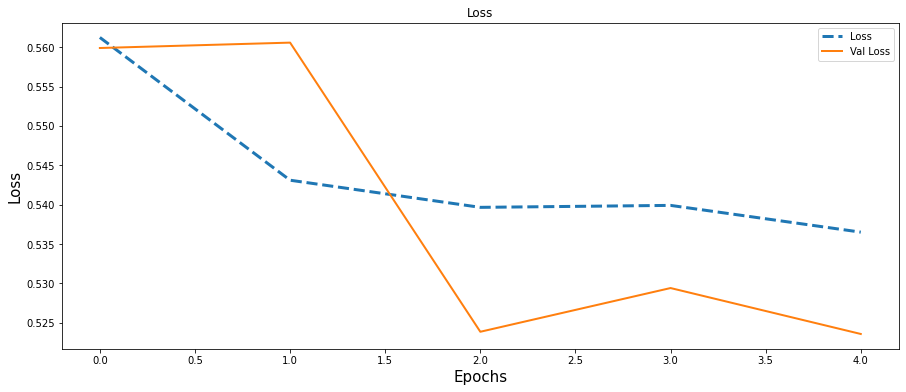

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(history.history['loss'], lw =3, ls = '--', label = 'Loss')
plt.plot(history.history['val_loss'], lw =2, ls = '-', label = 'Val Loss')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.title('Loss')
plt.legend()

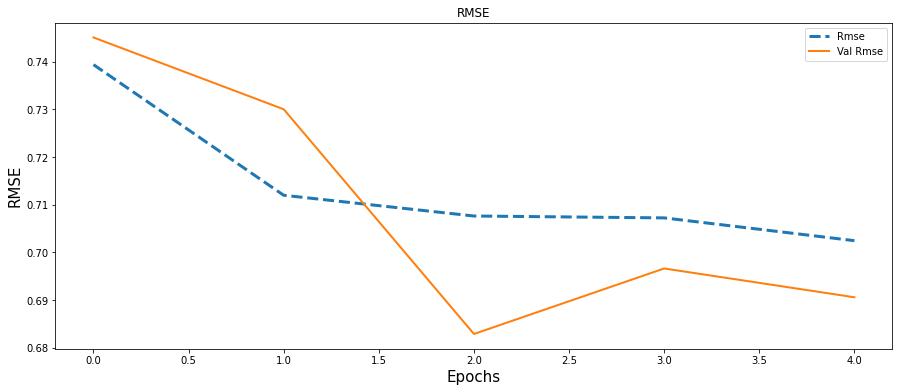

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(history.history['root_mean_squared_error'], lw =3, ls = '--', label = 'Rmse')
plt.plot(history.history['val_root_mean_squared_error'], lw =2, ls = '-', label = 'Val Rmse')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('RMSE', fontsize=15)
plt.title('RMSE')
plt.legend()

# **Classification**

Make Labels: 0-> low, 1->medium, 2->high earthquake magnitude

In [36]:
targets = [0,1,2]

In [37]:
y_class = np.where(y > 4.5, 2, 
         (np.where(y < 2, 0, 1)))

In [38]:
print("class 0:", len(y_class[y_class==0]))
print("class 1:", len(y_class[y_class==1]))
print("class 2:", len(y_class[y_class==2]))

class 0: 765034
class 1: 286774
class 2: 7146


In [39]:
from sklearn.model_selection import GroupShuffleSplit

# 60% Train, 20% Val, 20% Test
gs = GroupShuffleSplit(n_splits=1, test_size=.4, random_state=0)
train_ix, test_ix = next(gs.split(X, y_class, groups=grpId))

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST, grpId_TRAIN, grpId_TEST = X[train_ix], X[test_ix], y_class[train_ix], y_class[test_ix], grpId[train_ix], grpId[test_ix]

gs = GroupShuffleSplit(n_splits=1, test_size=.5, random_state=0)
val_ix, test_ix = next(gs.split(X_TEST, Y_TEST, groups=grpId_TEST))

X_VAL, X_TEST, Y_VAL, Y_TEST, grpId_VAL, grpId_TEST = X_TEST[val_ix], X_TEST[test_ix], Y_TEST[val_ix], Y_TEST[test_ix], grpId_TEST[val_ix], grpId_TEST[test_ix]

## XGB-Classifier

In [91]:
from xgboost import XGBClassifier

In [ ]:
model = XGBClassifier(max_depth=3,gamma=0, min_child_weight=1,objective='multi:softprob')
model.fit(X_TRAIN, Y_TRAIN)

XGBClassifier(objective='multi:softprob')

In [ ]:
y_pred = model.predict(np.vstack((X_TEST,X_VAL)))
y_predict = [round(value) for value in y_pred]
accuracy = accuracy_score(np.vstack((Y_TEST.reshape(-1,1),Y_VAL.reshape(-1,1))),y_predict)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(np.vstack((Y_TEST.reshape(-1,1),Y_VAL.reshape(-1,1))),y_predict))

Accuracy: 88.62%
              precision    recall  f1-score   support

           0       0.88      0.98      0.93    305928
           1       0.90      0.66      0.76    114643
           2       0.75      0.04      0.08      3000

    accuracy                           0.89    423571
   macro avg       0.85      0.56      0.59    423571
weighted avg       0.89      0.89      0.88    423571



### Upsample class 2

In [ ]:
from sklearn.utils import resample
X_class2 = resample(X_TRAIN[Y_TRAIN==2], 
                                 replace=True,     
                                 n_samples=(len(Y_TRAIN[Y_TRAIN==1])+len(Y_TRAIN[Y_TRAIN==0]))//2,    
                                 random_state=123)

In [ ]:
clf_model = XGBClassifier(max_depth=3,gamma=0, min_child_weight=1,objective='multi:softprob')
clf_model.fit(np.vstack((X_TRAIN,X_class2)),np.hstack((Y_TRAIN,[2 for _ in range(len(X_class2))])))
y_predict = clf_model.predict(np.vstack((X_TEST,X_VAL)))
print('Accuracy:',accuracy_score(np.vstack((Y_TEST.reshape(-1,1),Y_VAL.reshape(-1,1))),y_predict))
print(classification_report(np.vstack((Y_TEST.reshape(-1,1),Y_VAL.reshape(-1,1))),y_predict))

Accuracy: 0.8335249580353707
              precision    recall  f1-score   support

           0       0.88      0.98      0.93    305928
           1       0.90      0.43      0.59    114643
           2       0.10      0.90      0.18      3000

    accuracy                           0.83    423571
   macro avg       0.63      0.77      0.57    423571
weighted avg       0.88      0.83      0.83    423571



Downsample class 0 & 1

In [ ]:
X_class0 = resample(X_TRAIN[Y_TRAIN==0], 
                                 replace=True,     
                                 n_samples=len(Y_TRAIN[Y_TRAIN==2]),   
                                 random_state=123)
X_class1 = resample(X_TRAIN[Y_TRAIN==1], 
                                 replace=True,    
                                 n_samples=len(Y_TRAIN[Y_TRAIN==2]),    
                                 random_state=123)
X_class2 = X_TRAIN[Y_TRAIN==2]

X_123 = np.vstack((X_class0, X_class1, X_class2))
Y_123 = np.hstack(([0 for _ in range(len(X_class0))], [1 for _ in range(len(X_class1))], [2 for _ in range(len(X_class2))] )).ravel()
randomize = np.arange(len(X_123))
np.random.shuffle(randomize)
X_123 = X_123[randomize]
Y_123 = Y_123[randomize]


In [ ]:
clf_model = XGBClassifier(max_depth=3,gamma=0, min_child_weight=1,objective='multi:softprob')
clf_model.fit(X_123,Y_123)
y_predict = clf_model.predict(np.vstack((X_TEST,X_VAL)))
print('Accuracy:',accuracy_score(np.vstack((Y_TEST.reshape(-1,1),Y_VAL.reshape(-1,1))),y_predict))
print(classification_report(np.vstack((Y_TEST.reshape(-1,1),Y_VAL.reshape(-1,1))),y_predict))

Accuracy: 0.8219117928281209
              precision    recall  f1-score   support

           0       0.92      0.90      0.91    305928
           1       0.69      0.62      0.65    114643
           2       0.12      0.86      0.21      3000

    accuracy                           0.82    423571
   macro avg       0.58      0.79      0.59    423571
weighted avg       0.85      0.82      0.83    423571



## Decision Tree Classifier

Loading tuned Decision Tree GridsearchCV model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

In [ ]:
grid_params = {
    'criterion':['gini', 'entropy'],
    'max_depth':range(1,11),
    'min_samples_leaf':range(1,6),
    'min_samples_split':range(1,11),
    }

In [ ]:
dt_rand_grid = RandomizedSearchCV(estimator=DecisionTreeClassifier(),
                       param_distributions = grid_params,
                       n_iter = 100,
                       cv = list(GroupKFold(n_splits=3).split(X_TRAIN, Y_TRAIN, grpId_TRAIN)),
                       verbose=4
                       )
# dt_res = dt_rand_grid.fit(X_TRAIN,Y_TRAIN)

In [ ]:
dt_res = pickle.load( open('/content/drive/MyDrive/FML/models/decision_tree_randomsearchcv_res.pkl','rb'))
dt_res

RandomizedSearchCV(cv=[(array([     0,      2,      3, ..., 635379, 635380, 635382]),
                        array([     1,      5,     10, ..., 635377, 635378, 635381])),
                       (array([     1,      2,      3, ..., 635380, 635381, 635382]),
                        array([     0,      8,     11, ..., 635374, 635376, 635379])),
                       (array([     0,      1,      5, ..., 635378, 635379, 635381]),
                        array([     2,      3,      4, ..., 635375, 635380, 635382]))],
                   estimator=DecisionTreeClassifier(), n_iter=100,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(1, 11),
                                        'min_samples_leaf': range(1, 6),
                                        'min_samples_split': range(1, 11)},
                   verbose=4)

In [ ]:
dt_res.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 8}

### With imbalanced classes

In [ ]:
clf_model = DecisionTreeClassifier(criterion="gini", random_state=42,max_depth=10, min_samples_leaf=2, min_samples_split=8)   
clf_model.fit(X_TRAIN,Y_TRAIN)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=8,
                       random_state=42)

In [ ]:
y_predict = clf_model.predict(np.vstack((X_TEST,X_VAL)))

In [ ]:
print('Accuracy:',accuracy_score(np.vstack((Y_TEST.reshape(-1,1),Y_VAL.reshape(-1,1))),y_predict))

Accuracy: 0.8925469401824015


In [ ]:
print(classification_report(np.vstack((Y_TEST.reshape(-1,1),Y_VAL.reshape(-1,1))),y_predict))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93    305928
           1       0.88      0.70      0.78    114643
           2       0.53      0.20      0.29      3000

    accuracy                           0.89    423571
   macro avg       0.77      0.62      0.67    423571
weighted avg       0.89      0.89      0.89    423571



### Balanced classes

In [ ]:
dt_clf = DecisionTreeClassifier(criterion="gini", random_state=42,max_depth=10, min_samples_leaf=2, min_samples_split=8, class_weight='balanced')   
dt_clf.fit(X_TRAIN,Y_TRAIN)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=8,
                       random_state=42)

In [ ]:
y_predict = dt_clf.predict(np.vstack((X_TEST,X_VAL)))
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
print('Accuracy:',accuracy_score(np.vstack((Y_TEST.reshape(-1,1),Y_VAL.reshape(-1,1))),y_predict))

Accuracy: 0.831551262952374


In [ ]:
print(classification_report(np.vstack((Y_TEST.reshape(-1,1),Y_VAL.reshape(-1,1))),y_predict))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91    305928
           1       0.70      0.66      0.68    114643
           2       0.13      0.77      0.22      3000

    accuracy                           0.83    423571
   macro avg       0.58      0.78      0.60    423571
weighted avg       0.86      0.83      0.84    423571



### Upsample class 2

In [ ]:
from sklearn.model_selection import GroupShuffleSplit

# 60% Train, 20% Val, 20% Test
gs = GroupShuffleSplit(n_splits=1, test_size=.4, random_state=0)
train_ix, test_ix = next(gs.split(X, y_class, groups=grpId))

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST, grpId_TRAIN, grpId_TEST = X[train_ix], X[test_ix], y_class[train_ix], y_class[test_ix], grpId[train_ix], grpId[test_ix]

gs = GroupShuffleSplit(n_splits=1, test_size=.5, random_state=0)
val_ix, test_ix = next(gs.split(X_TEST, Y_TEST, groups=grpId_TEST))

X_VAL, X_TEST, Y_VAL, Y_TEST, grpId_VAL, grpId_TEST = X_TEST[val_ix], X_TEST[test_ix], Y_TEST[val_ix], Y_TEST[test_ix], grpId_TEST[val_ix], grpId_TEST[test_ix]

In [ ]:
X_class2 = resample(X_TRAIN[Y_TRAIN==2], 
                                 replace=True,     
                                 n_samples=(len(Y_TRAIN[Y_TRAIN==1])+len(Y_TRAIN[Y_TRAIN==0]))//2,    
                                 random_state=123)

In [ ]:
X_class2.shape

(315618, 58)

In [ ]:
clf_model = DecisionTreeClassifier(criterion="gini", random_state=42,max_depth=10, min_samples_leaf=2, min_samples_split=8)   
clf_model.fit(np.vstack((X_TRAIN,X_class2)),np.hstack((Y_TRAIN,[2 for _ in range(len(X_class2))])))
y_predict = clf_model.predict(np.vstack((X_TEST,X_VAL)))
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
print('Accuracy:',accuracy_score(np.vstack((Y_TEST.reshape(-1,1),Y_VAL.reshape(-1,1))),y_predict))


Accuracy: 0.8544470702668502


In [ ]:
print(classification_report(np.vstack((Y_TEST.reshape(-1,1),Y_VAL.reshape(-1,1))),y_predict))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93    305928
           1       0.88      0.54      0.67    114643
           2       0.12      0.81      0.21      3000

    accuracy                           0.85    423571
   macro avg       0.63      0.78      0.60    423571
weighted avg       0.89      0.85      0.86    423571



### Downsample class 0 & 1

In [ ]:
X_class0 = resample(X_TRAIN[Y_TRAIN==0], 
                                 replace=True,     
                                 n_samples=len(Y_TRAIN[Y_TRAIN==2]),   
                                 random_state=123)
X_class1 = resample(X_TRAIN[Y_TRAIN==1], 
                                 replace=True,    
                                 n_samples=len(Y_TRAIN[Y_TRAIN==2]),    
                                 random_state=123)
X_class2 = X_TRAIN[Y_TRAIN==2]

X_123 = np.vstack((X_class0, X_class1, X_class2))
Y_123 = np.hstack(([0 for _ in range(len(X_class0))], [1 for _ in range(len(X_class1))], [2 for _ in range(len(X_class2))] )).ravel()
randomize = np.arange(len(X_123))
np.random.shuffle(randomize)
X_123 = X_123[randomize]
Y_123 = Y_123[randomize]


In [ ]:
Y_123.shape

(12438,)

In [ ]:
clf_model = DecisionTreeClassifier(criterion="gini", random_state=42,max_depth=10, min_samples_leaf=2, min_samples_split=8)   
clf_model.fit(X_123,Y_123)
y_predict = clf_model.predict(np.vstack((X_TEST,X_VAL)))
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
print('Accuracy:',accuracy_score(np.vstack((Y_TEST.reshape(-1,1),Y_VAL.reshape(-1,1))),y_predict))

Accuracy: 0.7912652188180966


In [ ]:
print(classification_report(np.vstack((Y_TEST.reshape(-1,1),Y_VAL.reshape(-1,1))),y_predict))

              precision    recall  f1-score   support

           0       0.92      0.85      0.89    305928
           1       0.62      0.62      0.62    114643
           2       0.11      0.83      0.19      3000

    accuracy                           0.79    423571
   macro avg       0.55      0.77      0.56    423571
weighted avg       0.83      0.79      0.81    423571



### Decision Tree Graph

In [ ]:
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(dt_clf,
                                out_file=None, 
                      feature_names=feature_names,  
                      class_names=[str(i) for i in targets],  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data) 
graph

In [ ]:
from sklearn.tree import export_text
r = export_text(dt_clf, feature_names=feature_names)
print(r)


|--- p_weight <= 0.50
|   |--- source_magnitude_type_col_4 <= 0.50
|   |   |--- source_magnitude_type_col_1 <= 0.50
|   |   |   |--- source_latitude <= 17.37
|   |   |   |   |--- source_depth_km <= 107.67
|   |   |   |   |   |--- source_latitude <= 13.00
|   |   |   |   |   |   |--- p_travel_sec <= 7.62
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- p_travel_sec >  7.62
|   |   |   |   |   |   |   |--- source_magnitude_type_col_0 <= 0.50
|   |   |   |   |   |   |   |   |--- source_depth_km <= 1.11
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- source_depth_km >  1.11
|   |   |   |   |   |   |   |   |   |--- source_longitude <= 179.96
|   |   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |   |   |--- source_longitude >  179.96
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- source_magnitude_type_col_0 >  0.50
|   |   |   |   |   |   |   |   |--- source_id_co

In [ ]:
graph.save('graph1.jpg')